# Linear Regression

In this task we'll create a linear regression model to predict car prices.

**Linear Regression from the business perspective of Mobile.de/Craigslist:**

Big online car-marketplaces have hundreds of thousands of sales and advertisements uploaded daily. With that many car offers, it might be interesting to investigate how good car prices can be predicted, based solely on the underlying technical make of the car (like engine, drive, ect...) and the input from the car advertisers (condition, location, etc...). A good linear regression model could help identify outlier offers, guide the customer by setting a price expectation on his particular car configuration, or the other way around, giving the advertiser a price recommendation for his offer.


**Linear Regression in the technical sense:**

While in theory a linear regression model sounds like a great tool that could have applications in a large variety of ways, linear regression often has its limits with a lot of data in the real world (excluding observations in natural sciences like physics). A lot of data is messy/noisy and this car dataset is no exception. As seen in the preprocessing/exploration phase, even after extensive data cleansing there still is no high correlation to be found between the features. A high correlation between predictor variables and label is highly desirable in linear regression. We need to see whether it is possible to create an exceptable model out of a dataset with low-mid correlating features. 

To ensure that we can iterate through this dataset multiple times in an efficient manner, we'll try to integrate our process into a pipeline, such that, ideally, we'd only need to tweak some parameters.

# Setup

In [ ]:
from google.colab import drive
import os

# skip, if not running on Google Colab
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [ ]:
# import modules and set options
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.compose import make_column_selector as selector


pd.options.display.max_rows = 100 #default = 60
sns.set_theme(style="whitegrid")

In [ ]:
# load pickle dataset into DataFrame
df = pd.read_pickle('df_std_no_outlier')
df = df.drop(columns=['price'])
print(df.shape)

# replace transformed label with non-transformed label to predict on actual prices
label_df = pd.read_pickle('df_impute_no_outlier')
label_df = label_df['price']
df = df.join(label_df)
df

(76133, 17)


,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,price
31,auburn,0.250,ford,f-150 xlt,0.0,0.0,gas,0.143159,clean,automatic,rwd,0.0,truck,black,al,-0.922756,0.044555,15000.0
55,auburn,-0.875,ford,f250 super duty,-1.0,0.5,diesel,-0.360213,clean,automatic,4wd,0.0,pickup,blue,al,-0.928864,0.046607,19900.0
59,auburn,0.125,honda,odyssey,0.0,0.0,gas,-0.272123,clean,automatic,fwd,0.0,mini-van,silver,al,-0.917714,0.046866,14000.0
65,auburn,-1.250,ford,f450,-1.0,0.5,diesel,0.353317,clean,manual,rwd,0.0,truck,white,al,-0.917486,0.049303,22500.0
73,auburn,0.750,dodge,charger rt 4dr sedan,0.0,0.5,gas,-0.335045,rebuilt,automatic,rwd,-1.0,sedan,grey,al,-0.891134,0.034375,15000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,wyoming,-0.750,chevrolet,silverado 1500 lt 4x4,0.0,0.5,gas,0.168328,lien,automatic,4wd,0.0,truck,blue,wy,0.567862,-0.976336,18000.0
426809,wyoming,-2.625,jeep,gand wagoneer,-1.0,0.5,gas,-0.027988,clean,automatic,4wd,0.0,SUV,black,wy,0.567862,-0.976336,18000.0
426831,wyoming,-3.250,nissan,300zx coupe with t-tops,1.0,0.0,gas,-0.020437,clean,automatic,rwd,-3.0,hatchback,red,wy,0.250943,-0.735767,9800.0
426833,wyoming,-1.750,jaguar,xk8 convertible,-1.0,0.5,gas,-0.592394,clean,automatic,rwd,-2.0,convertible,white,wy,0.593956,-0.874478,6800.0


# Feature Selection

Choosing the right predictor variables has a large impact on the performance of the regression model.
Generally speaking, the choice of features can be determined by its correlation to the output variable and the correlation between other predictor variables.

We want features that strongly correlate with the label, but at the same time we don't want strong correlation between the features themselves.

As a manual data selection process, we'll...

1. Select features based on their correlation to the label
2. See which features have a correlation to other features...
3. ...and remove the feature of the bunch that has the lowest correlation to the label


Since we still have some nominal features (e.g. paint) that haven't been examined yet, we'll one-hot encode them and see wheter there are suitable features that can be used for our linear regression

## Manual feature selection

In [ ]:
# remove model, manufacturer, region, state for one hot encoding since there are so many unique values
# manufacturer: 41, model: 8k+, region: 400+, state: 51
df = df.drop(['manufacturer', 'model', 'region', 'state'], axis=1)
df

,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
31,0.250,0.0,0.0,gas,0.143159,clean,automatic,rwd,0.0,truck,black,-0.922756,0.044555,15000.0
55,-0.875,-1.0,0.5,diesel,-0.360213,clean,automatic,4wd,0.0,pickup,blue,-0.928864,0.046607,19900.0
59,0.125,0.0,0.0,gas,-0.272123,clean,automatic,fwd,0.0,mini-van,silver,-0.917714,0.046866,14000.0
65,-1.250,-1.0,0.5,diesel,0.353317,clean,manual,rwd,0.0,truck,white,-0.917486,0.049303,22500.0
73,0.750,0.0,0.5,gas,-0.335045,rebuilt,automatic,rwd,-1.0,sedan,grey,-0.891134,0.034375,15000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,-0.750,0.0,0.5,gas,0.168328,lien,automatic,4wd,0.0,truck,blue,0.567862,-0.976336,18000.0
426809,-2.625,-1.0,0.5,gas,-0.027988,clean,automatic,4wd,0.0,SUV,black,0.567862,-0.976336,18000.0
426831,-3.250,1.0,0.0,gas,-0.020437,clean,automatic,rwd,-3.0,hatchback,red,0.250943,-0.735767,9800.0
426833,-1.750,-1.0,0.5,gas,-0.592394,clean,automatic,rwd,-2.0,convertible,white,0.593956,-0.874478,6800.0


In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

df_onehot = df.copy()
onehot = pd.get_dummies(df_onehot.select_dtypes(exclude=np.number))
df_onehot = df_onehot.join(onehot)
df_onehot = df_onehot.select_dtypes(exclude=['object'])
df_onehot

,year,condition,cylinders,odometer,size,lat,long,price,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,title_status_clean,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,type_SUV,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
31,0.250,0.0,0.0,0.143159,0.0,-0.922756,0.044555,15000.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
55,-0.875,-1.0,0.5,-0.360213,0.0,-0.928864,0.046607,19900.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
59,0.125,0.0,0.0,-0.272123,0.0,-0.917714,0.046866,14000.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
65,-1.250,-1.0,0.5,0.353317,0.0,-0.917486,0.049303,22500.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
73,0.750,0.0,0.5,-0.335045,-1.0,-0.891134,0.034375,15000.0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,-0.750,0.0,0.5,0.168328,0.0,0.567862,-0.976336,18000.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
426809,-2.625,-1.0,0.5,-0.027988,0.0,0.567862,-0.976336,18000.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
426831,-3.250,1.0,0.0,-0.020437,-3.0,0.250943,-0.735767,9800.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
426833,-1.750,-1.0,0.5,-0.592394,-2.0,0.593956,-0.874478,6800.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# select dataframe
df_corr = df_onehot

corr_pearson = df_corr.corr(method='pearson')
corr_spearman = df_corr.corr(method='spearman')
corr_kendall = df_corr.corr(method='kendall')
corr_list = [corr_pearson, corr_spearman, corr_kendall]

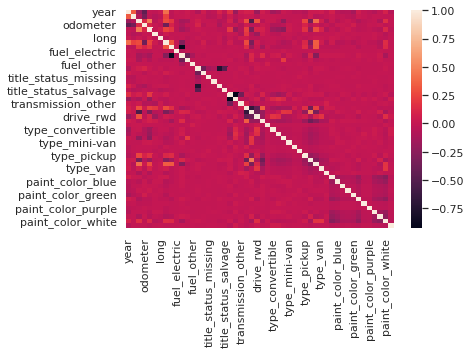

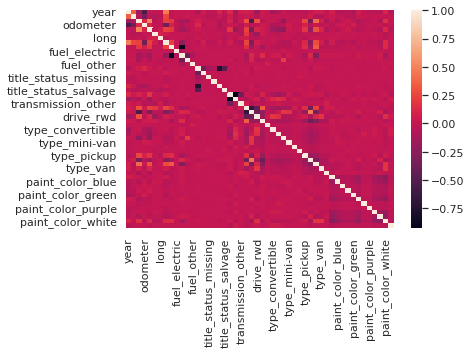

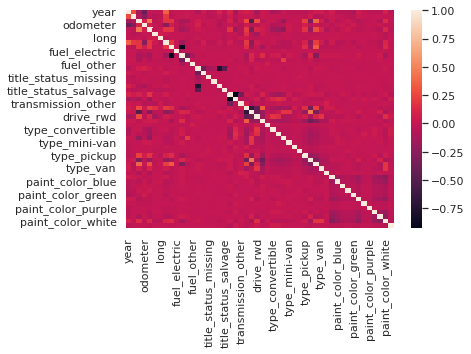

In [ ]:
for elem in corr_list:
  sns.heatmap(elem)
  #print(elem)
  plt.show()

In [ ]:
correlation = corr_pearson.copy()
#correlation = corr_spearman.copy()
#correlation = corr_kendall.copy()

corr_overview = pd.DataFrame(columns=['feature_1', 'feature_2', 'value'])

coef = 0.2

for col, rows in correlation.iterrows():
  #print(correlation.at[col, rows.index[0]])
  for index, values in enumerate(rows):
    if abs(correlation.at[col, rows.index[index]]) < coef:
      correlation.at[col, rows.index[index]] = np.NaN
    else:
      corr_overview = corr_overview.append({'feature_1': col, 'feature_2': rows.index[index], 'value': correlation.at[col, rows.index[index]]}, ignore_index=True)


#corr_overview = corr_overview.loc[corr_overview.value != 1]
corr_overview.sort_values(by='value')

,feature_1,feature_2,value
74,transmission_manual,transmission_automatic,-0.921939
72,transmission_automatic,transmission_manual,-0.921939
50,fuel_gas,fuel_diesel,-0.898483
46,fuel_diesel,fuel_gas,-0.898483
66,title_status_rebuilt,title_status_clean,-0.755910
...,...,...,...
152,paint_color_white,paint_color_white,1.000000
75,transmission_manual,transmission_manual,1.000000
71,transmission_automatic,transmission_automatic,1.000000
99,drive_rwd,drive_rwd,1.000000


In [ ]:
label_corr = corr_overview.loc[corr_overview.feature_1 == 'price'].sort_values('value', ascending=False)
label_corr

,feature_1,feature_2,value
37,price,price,1.000000
32,price,year,0.421106
43,price,type_truck,0.342607
38,price,fuel_diesel,0.316701
34,price,cylinders,0.278332
40,price,drive_4wd,0.275555
36,price,size,0.242990
33,price,condition,0.238771
42,price,type_sedan,-0.264365
39,price,fuel_gas,-0.278014


These are all the features that have at least a weak correlation (+-0.2) to our label 'price'. All these features will be selected. In the next step, we'll filter out the remaining features



**Interpreting our Correlation (R)**

Sometimes using the R² (Correlation x Correlation) helps to get a better understanding of the meaning behind the correlation coefficient.

We know that R² explains the relationship between our feature x and our label y in %.

If we take the square or out highest correlating feature to our label 'year' with a coefficient of 0.42, we get our R² value, which gets us the percentage of how well this feature explains our label:

0.42² = 0.1764

17,64% of the variation of our label can be explained by feature 'year'. This doesn't sound like much, and it isn't, but we can't forget that we also have other features that 'try' to explain our label. 

In other words, a low R² value is especially critical with few features.

In [ ]:
# Selects features that correlate with label
def feature_selector(df, df_corr):
  feature_list = list(df_corr.feature_2)
  return df[feature_list]


In [ ]:
df_selection_1 = feature_selector(df_onehot, label_corr)
df_selection_1

,price,year,type_truck,fuel_diesel,cylinders,drive_4wd,size,condition,type_sedan,fuel_gas,drive_fwd,odometer
31,15000.0,0.250,1,0,0.0,0,0.0,0.0,0,1,0,0.143159
55,19900.0,-0.875,0,1,0.5,1,0.0,-1.0,0,0,0,-0.360213
59,14000.0,0.125,0,0,0.0,0,0.0,0.0,0,1,1,-0.272123
65,22500.0,-1.250,1,1,0.5,0,0.0,-1.0,0,0,0,0.353317
73,15000.0,0.750,0,0,0.5,0,-1.0,0.0,1,1,0,-0.335045
...,...,...,...,...,...,...,...,...,...,...,...,...
426808,18000.0,-0.750,1,0,0.5,1,0.0,0.0,0,1,0,0.168328
426809,18000.0,-2.625,0,0,0.5,1,0.0,-1.0,0,1,0,-0.027988
426831,9800.0,-3.250,0,0,0.0,0,-3.0,1.0,0,1,0,-0.020437
426833,6800.0,-1.750,0,0,0.5,0,-2.0,-1.0,0,1,0,-0.592394


In [ ]:
# We can take a closer look at the correlation of our selected features
corr_overview.loc[corr_overview.feature_1 == 'year'].sort_values('value', ascending=False)

,feature_1,feature_2,value
0,year,year,1.000000
3,year,price,0.421106
1,year,condition,0.335220
2,year,odometer,-0.448159


Deciding which features to remove often isn't as clear-cut as one would hope it would be. Especially with a dataset that doesn't have strong correlations between each features to begin with. In such a case, what exactly constitues a feature that would need to be removed? 

Let's take feature 'year': This predictor variable has the highest correlation to our label. When looking for its correlation between other predictor variables, you can see that it has even a higher correlation with feature 'odometer', which has the second largest correlation to the label. In relative terms, both 'odometer' and 'year' have a high correlation and therefore one should be removed. In absolute terms this correlation still only is a weak-mid correlation, meaning that 'odometer' doesn't really explain 'year' that well.

Perhaps it is best to let an algorithm decide which features would be the best fit for a regression model. This can be done with Recursive Feature Elimination, which will be applied in the next step.

## Feature Selection with Recursive Feature Elimination

Recursive Feature Elimination (RFE) is a wrapper-type feature selection algorithm. This means that an actual machine learning algorithm is used to determine the features that are going to be used on the actual model training. These machine learning results are then used to make a filter-based feature selection.

In this case we'll do the backward elimination approach, meaning that the simple wrapper model will be iteratively trained. Each iteration removes a feature as long as the model performance improves.  

In [ ]:
# Split features and labels
X, y = df_selection_1.loc[:, df_selection_1.columns != 'price'], df_selection_1['price']
#X, y = df_onehot.loc[:, df_onehot.columns != 'price'], df_onehot['price']



RFECV (**RFE** with **C**ross-**V**alidation) chooses our features based on results of a cross-validation.

Since we lack intuition in feature selection as well as the dataset at hand, we'll delegate the feature selection to the RFECV method.

In [ ]:
# define RFE
rfe = RFECV(estimator=LinearRegression())
# fit RFE
print(X.shape)
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
  print('Column: %s, Selected=%s, Rank: %d' % (df_selection_1.columns[i], rfe.support_[i], rfe.ranking_[i]))

# Algo biased to what got kicked out first
df_test = rfe.transform(X)
df_test.shape


(76133, 11)
Column: price, Selected=True, Rank: 1
Column: year, Selected=True, Rank: 1
Column: type_truck, Selected=True, Rank: 1
Column: fuel_diesel, Selected=True, Rank: 1
Column: cylinders, Selected=True, Rank: 1
Column: drive_4wd, Selected=True, Rank: 1
Column: size, Selected=True, Rank: 1
Column: condition, Selected=True, Rank: 1
Column: type_sedan, Selected=True, Rank: 1
Column: fuel_gas, Selected=True, Rank: 1
Column: drive_fwd, Selected=True, Rank: 1


(76133, 11)

RFECV with LinearRegression as estimator chooses to keep all features.

RFECV with the DecisionTreeRegressor on the other hand removes 1-2 (usually type_sedan and condition)

We'll continue with all variables

# Model

- For our model, we'll choose Lasso Regression. In contrast to the naive linear regression, Lasso also has an additional reguralization parameter, that counteracts variance in the training in favor of bias. This should avoid overfitting a model. Another benificial side effect of the reguralization parameter is the cancellation of weak features. While the model accuracies are comparable 

In [ ]:
# Splitting our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Next we standardize our features again
In contrast to the preprocessing phase, we'll only use the StandardScaler this time, as we only want to nudge our mean and std back to 0 and 1, after splitting the data

We are not going standardize the one-hot encoded features as they are binary.

In [ ]:
list_numerical = ['year', 'cylinders', 'condition', 'size', 'odometer']

scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

X_train

,year,type_truck,fuel_diesel,cylinders,drive_4wd,size,condition,type_sedan,fuel_gas,drive_fwd,odometer
333126,0.356903,0,0,-1.164024,0,-0.496590,-0.984793,0,1,1,1.561889
140501,0.976890,0,0,-1.164024,0,0.793872,1.641830,1,1,1,-0.359241
22089,0.666896,1,1,0.048389,1,0.793872,0.328519,0,0,0,-0.091682
152612,-0.108087,0,0,-1.164024,0,0.793872,-0.984793,1,1,1,0.590494
354152,1.286884,0,0,-1.164024,0,-0.496590,0.328519,1,1,1,-1.270736
...,...,...,...,...,...,...,...,...,...,...,...
104753,0.821893,0,0,0.048389,0,0.793872,0.328519,0,1,1,-0.611304
213027,0.511900,0,0,0.048389,1,0.793872,0.328519,0,1,0,0.042347
63202,-0.418081,0,0,0.048389,0,0.793872,0.328519,1,1,1,0.533060
57778,0.356903,0,0,0.048389,0,0.793872,1.641830,1,1,1,0.099481


## Naive first-look implementation

In [ ]:
# reg param = 1
reg_1 = Lasso(alpha=4)
reg_1.fit(X_train, y_train)

# reg param = 0
reg_0 = Lasso(alpha=0)
reg_0.fit(X_train, y_train)

# linear regression (should be same as alpha = 0)
lin = LinearRegression()
lin.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e+12, tolerance: 6.334e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, 

LinearRegression()

In [ ]:
# lasso 1
print('lasso 1')
print('R squared training set', round(reg_1.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg_1.score(X_test, y_test)*100, 2))
print()
# lasso 0
print('lasso 0')
print('R squared training set', round(reg_0.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg_0.score(X_test, y_test)*100, 2))
print()
# linear
print('linear')
print('R squared training set', round(lin.score(X_train, y_train)*100, 2))
print('R squared test set', round(lin.score(X_test, y_test)*100, 2))


lasso 1
R squared training set 50.02
R squared test set 48.52

lasso 0
R squared training set 50.02
R squared test set 48.52

linear
R squared training set 50.02
R squared test set 48.52


In [ ]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = reg_1.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg_1.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 59397124.46
MSE test set 58762258.17


linear and lasso 0 are the have the same result, which is to be expected. Lasso with alpha = 1 as well, if we tweak our reg. param to 50 we can see a drop in train accuracy, but a very slight increase in test accuracy.

Finding optimal alpha by trial and error is not efficient, which is why we'll do an algorithmic approacht ot find the best param

## Methodical implementation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e+12, tolerance: 6.334e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, 

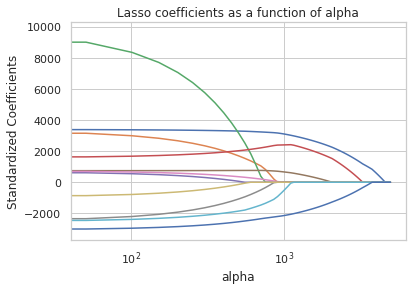

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0,5000,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

We can see how different features assume their coefficient estimates at different values of alpha. 

In [ ]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [ ]:
model.alpha_

4.6235246427531225

In [ ]:
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=4.6235246427531225)

In [ ]:
print(list(zip(lasso_best.coef_, X)))

[(3388.5338811275715, 'year'), (3292.8211228599243, 'type_truck'), (9582.797038080384, 'fuel_diesel'), (1589.7395857624815, 'cylinders'), (664.8532604156856, 'drive_4wd'), (741.9289100055461, 'size'), (729.5007567463837, 'condition'), (-2468.292609649134, 'type_sedan'), (-932.2383154922569, 'fuel_gas'), (-2510.684711947049, 'drive_fwd'), (-3049.5113867495047, 'odometer')]


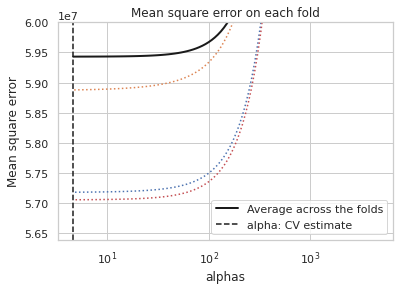

In [ ]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

# ymin, ymax = 50397124, 79397124
ymin, ymax = 56397124, 60000000
plt.ylim(ymin, ymax);

This model doesn't really seem to profit from the regularization parameter.
We'll try different features once we embedded everything in a pipeline.

# Final look at the results

In [ ]:
# Calculate Mean Average Error
y_pred = model.predict(X_test)
y_pred = np.around(y_pred)
y_pred_df = pd.DataFrame({'y_pred': y_pred, 'y_actual': y_test, 'residual': abs(y_pred - y_test), 'rss': (y_pred - y_test)**2})
mae = y_pred_df['residual'].sum()/y_pred_df.shape[0]
print('MAE:\t', mae)

std = y_pred_df['y_actual'].std()
print('1 std:\t', std)

MAE:	 5227.498905429072
1 std:	 10684.577297538533


On average, we miscalculate the price of cars by over $5.000.

On average, our model fails to predict our values by half of one standard deviation.

In [ ]:
import math
# RSE Residual Standard Error

# 1. RSS (Residual Sum of Squares)

rss = (y_pred_df['rss'].sum())
n = y_pred_df.shape[0]

rse = math.sqrt((1/(n-2))*rss)
rse

7665.946205923516

We have a RSE of $7666.

In [ ]:
# data points in table form
y_pred_df

,y_pred,y_actual,residual,rss
199710,21392.0,17995.0,3397.0,11539609.0
193142,7379.0,3995.0,3384.0,11451456.0
364181,29126.0,39999.0,10873.0,118222129.0
268781,22412.0,24660.0,2248.0,5053504.0
324787,11986.0,12999.0,1013.0,1026169.0
...,...,...,...,...
230219,16585.0,22599.0,6014.0,36168196.0
367137,6571.0,6750.0,179.0,32041.0
116904,26513.0,29898.0,3385.0,11458225.0
356717,20128.0,21995.0,1867.0,3485689.0


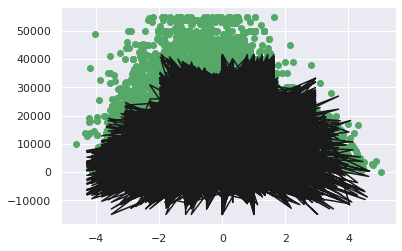

In [ ]:
# plot visualization of our model
from sklearn.decomposition import PCA
sns.set_theme(color_codes=True)

pca = PCA(n_components=1)

X_test_pca = pca.fit_transform(X_test)

plt.scatter(X_test_pca, y_test, color='g')
plt.plot(X_test, model.predict(X_test),color='k')

plt.show()

... This is what happens when you try to plot a multidimensional regression on a 2D plane...

# Evaluation

Evaluation has functions of calculations that have been done above. This is to implement these into a Pipeline. These evaluation metrics will also be explained in greater detail

- MAE (Mean Average Error)
- RSE (Residual Standard Error)
- R² (R-Squared)

## MAE

The Mean Average Error is a simple calculation to determine how large the data points diverge from the regression (residuals) in average. This is done by taking the sum of the absolute values of the residuals and dividing them by the degrees of freedom.

In [ ]:
def mae(X, y, model):
  y_pred = np.around(model.predict(X))
  y_pred_df = pd.DataFrame({'y_pred': y_pred, 'y_actual': y, 'residual': abs(y_pred - y)})

  mae = y_pred_df['residual'].sum()/y_pred_df.shape[0]
  return mae

In [ ]:
print('MAE of train data:\t', mae(X_train, y_train, model))
print('MAE of test data:\t', mae(X_test, y_test, model))


MAE of train data:	 5260.748747490289
MAE of test data:	 5227.498905429072


## RSE

Residual Standard Error measures the standard deviation from which predictions would diverge from the actual regression line. Intuitively speaking, even if we found the perfect coefficients for our regression model, we'd have to assume an expected deviation of the output of RSE. The RSE returns an absolute value in the unit of our label. (In our case the units of 'price', which are Dollars)
In order to make sense of our RSE value, it's important that our label isn't transformed, so we can read our RSE in Dollars and interpret this value accordingly. 

In [ ]:
# Our RSE method
import math

def rse(X, y, model):
  y_pred = model.predict(X)
  rss = ((y_pred - y)**2).sum()
  n = y.shape[0]
  rse = math.sqrt((1/(n-2))*rss)
  return rse

In [ ]:

print(rse(X_train, y_train, model))
print(rse(X_test, y_test, model))

7707.105899965056
7665.946613414338


## (Adjusted) R²

The quality of the RSE value can only be measured within the context of the same distribution, since the result is relative to the label.
To have a more general sense of our model quality, we measure the R² value. R² measures the variability of our Regression that can be explained using our set of predictor variables. Low R² values are a product of high variance error, which can either result from a wrong model fit, or a dataset with scattered datapoints. In other words a R² score of 0 means that the response (predicted y) cannot be explained by our predictors (X). Vice versa, a score of 1 means that our features perfectly explain the results of our regression model.

If we transfer this to our use case, a R² value of 0.75, would mean that 3/4 of the variability in our dataset can be explained by our trained model.

In [ ]:
print('R²', round(model.score(X_train, y_train)*100, 2))
print('R²', round(model.score(X_test, y_test)*100, 2))

R² 50.02
R² 48.52


#Pipeline

1. Ingest data (after manual feature selection)
2. One-hot encoding
3. Subsequent feature selection with RFECV
4. model training and hyper param selection
5. model evaluation

In [ ]:
def regression_pipeline(df, label, fs_estimator):
  
  # separate features from label
  X, y = df.loc[:, df.columns != label], df_selection_1[label]

  # feature selection

  onehot = OneHotEncoder(handle_unknown='ignore')
  rfe = RFECV(estimator=fs_estimator)
  
  feature_pipe = Pipeline(steps=[
    ('onehot', onehot),
    ('feature_selector', rfe)          
  ])

  df = feature_pipe.fit_transform(X, y)




  return test


In [ ]:
test = regression_pipeline(df, 'price', LinearRegression())
test

KeyboardInterrupt: ignored

# Conclusion